In [27]:
ls

Aggregation.txt    animation-d.mp4  jain40frames.mp4  README.md
animation-400.mp4  animation.mp4    jain.txt          spiral20frames.mp4
animation-b.mp4    Compound.txt     pogo.ipynb        spiral40frames.mp4
animation-c.mp4    D31.txt          R15.txt           spiral.txt


In [28]:
ls datasets


ls: cannot access 'datasets': No such file or directory


In [29]:
import numpy as np
import pandas as pd
import gudhi

In [30]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [31]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics


In [32]:
%matplotlib inline

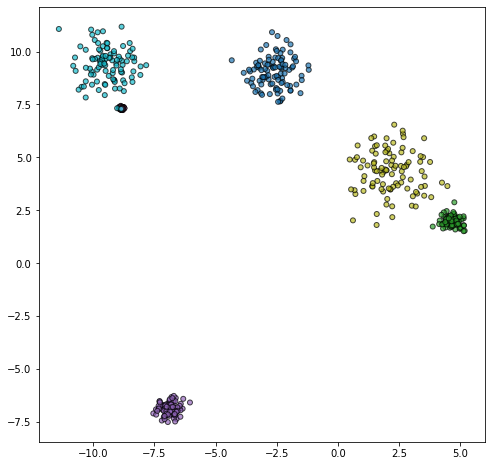

In [33]:
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)

size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [ ]:
iris = load_iris()
X = iris.data
y = iris.target

In [63]:
X = np.loadtxt('D31.txt')

In [68]:
X[:,0]

array([25.0514, 26.6614, 25.2653, ...,  5.276 ,  6.4444,  7.162 ])

In [69]:
y = X[:,2]

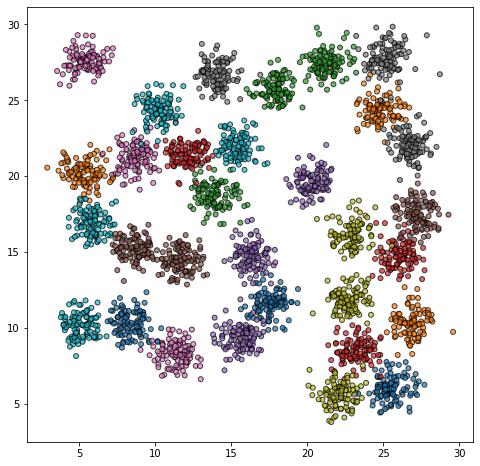

In [70]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [71]:
rips_complex = gudhi.RipsComplex(points=X,)
                                 #max_edge_length=1)


In [72]:

simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)


#for i in simplex_tree.get_filtration():
#    print(i)
    
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())


3100 vertices
4806550 simplices
dimension: 1


In [73]:
#simplex_tree.prune_above_filtration(.9)

In [74]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []

for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:    
        if all(value != 0 for value in list(point_dict.values())):
            print('break')
            print(simplex)
            break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())


break
([1353, 1369], 1.6519092529554997)


In [75]:
len(cluster_dict_list)

106826

In [76]:
#convert the simplex tree to a pandas dataframe
df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])

In [77]:
df = df[:len(cluster_dict_list)]
df

,simplex,distance
0,[0],0.000000
1,[1],0.000000
2,[2],0.000000
3,[3],0.000000
4,[4],0.000000
...,...,...
106821,"[1042, 1077]",1.607303
106822,"[2845, 2864]",1.607303
106823,"[216, 262]",1.607303
106824,"[2718, 2723]",1.607371


In [78]:
#find the gaps between birth/death pairs
df['gaps'] = df['distance'] - df['distance'].shift(1)

In [79]:
#find normalized distance
scaler = MinMaxScaler()
df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

In [80]:
df['normed_gaps'] = df['gaps'] * df['normed_distance']

In [81]:
sum = df['normed_gaps'].sum()
#print(sum)
df['probability_vector'] = df['normed_gaps'] / sum

In [82]:
#sum(df.loc[:,'probability_vector'])

In [83]:
df.nlargest( 60,['gaps'])

,simplex,distance,gaps,normed_distance,normed_gaps,probability_vector
3109,"[2817, 2839]",0.013800,0.003514,0.008585,0.000030,0.000038
3107,"[2125, 2155]",0.009758,0.002485,0.006071,0.000015,0.000019
3100,"[1831, 1894]",0.002300,0.002300,0.001431,0.000003,0.000004
3106,"[1011, 1070]",0.007273,0.002130,0.004525,0.000010,0.000012
3104,"[72, 78]",0.004600,0.001347,0.002862,0.000004,0.000005
3128,"[318, 366]",0.023000,0.001302,0.014309,0.000019,0.000023
3202,"[924, 980]",0.040950,0.001246,0.025476,0.000032,0.000040
3122,"[1630, 1686]",0.017964,0.001219,0.011176,0.000014,0.000017
3184,"[1531, 1574]",0.037086,0.001159,0.023072,0.000027,0.000033
3125,"[3063, 3092]",0.019651,0.001108,0.012226,0.000014,0.000017


In [84]:
df.nlargest( 40,['probability_vector'])

,simplex,distance,gaps,normed_distance,normed_gaps,probability_vector
98738,"[1360, 1395]",1.496105,0.000149,0.930769,0.000138,0.000172
100266,"[2424, 2450]",1.516963,0.000139,0.943745,0.000132,0.000164
105941,"[2483, 2491]",1.595273,0.000128,0.992465,0.000127,0.000158
104780,"[319, 339]",1.578687,0.000121,0.982145,0.000118,0.000147
105740,"[1181, 1194]",1.592173,0.000115,0.990536,0.000114,0.000141
105992,"[2805, 2821]",1.596091,0.000114,0.992973,0.000114,0.000141
80666,"[939, 953]",1.271806,0.000141,0.791227,0.000112,0.000139
106651,"[935, 995]",1.605204,0.000112,0.998643,0.000112,0.000139
88537,"[363, 394]",1.365855,0.000128,0.849737,0.000109,0.000135
93323,"[409, 411]",1.425527,0.000121,0.886861,0.000107,0.000133


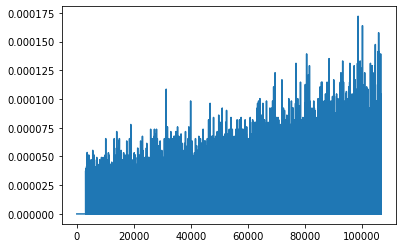

In [85]:
plt.plot(df['probability_vector'])

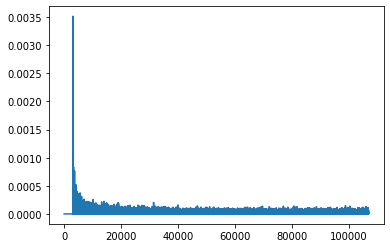

In [86]:
plt.plot(df['gaps'])

In [87]:
%time
%time idx = min(df.nlargest( 60,['probability_vector']).index)
print(idx)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.82 µs
CPU times: user 23.7 ms, sys: 626 µs, total: 24.3 ms
Wall time: 21.9 ms
31389


In [25]:
 #metrics.silhouette_score(X, pred, metric="euclidean")

In [26]:
length = len(cluster_dict_list)-1
silhouette_scores = []

for i in range(length):
    pred = np.array(list(cluster_dict_list[i].values()))
    silhouette_scores.append(metrics.silhouette_score(X, pred, metric="euclidean"))

KeyboardInterrupt: 

In [ ]:
plt.plot(silhouette_scores)

In [88]:
idx=len(df)-1

In [ ]:
idx = silhouette_scores.index(max(silhouette_scores[simplex_tree.num_vertices():idx]))
print(idx)

In [89]:
np.array(list(cluster_dict_list[idx].values()))

array([5, 5, 5, ..., 3, 3, 3])

In [90]:

print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

your dataset appears to have 28 clusters


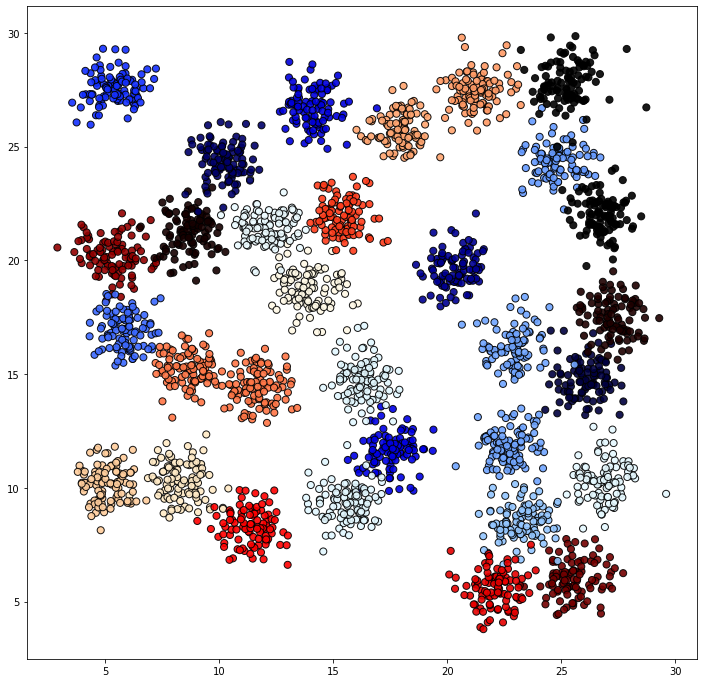

In [91]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

3560


<ipython-input-93-b75bb8bc3d7e>:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


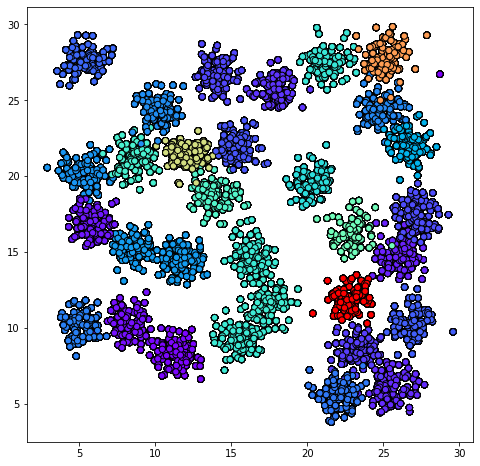

In [93]:
fig, ax = plt.subplots(figsize=(8,8))
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)

def init():
    scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[0].values())),
                    marker="o",
                    cmap='rainbow',
                    norm=None,
                    alpha=1,
                    edgecolor="k")
    #ax.set(xlim=(-1, 35), ylim=(-1, 35))

    return scatter,

#collection = PatchCollection(X, animated=True)

#ax.add_collection(collection)
#ax.autoscale_view(True)

def animate(i):

    scatter = ax.scatter(X[:, 0], X[:, 1],
                s=40, 
                c=np.array(list(cluster_dict_list[i*interval].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=1,
                edgecolor="k")
    return scatter,
    
    
    
ani = FuncAnimation(fig, animate,interval=400,init_func=init,frames=frames,repeat=False, blit=True)

ani.save('animation.gif')



writer=animation.PillowWriter()

writer = animation.FFMpegWriter(fps=2,bitrate=1000)

#ani.save('animation-c.gif', writer=writer, dpi=250)
fig.show()


In [ ]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

In [ ]:
rand_score_list = []
true = y
for i in range(len(cluster_dict_list)):
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [ ]:
 plt.plot(rand_score_list)

In [ ]:
max(rand_score_list)

In [ ]:
rand_score_list.index(max(rand_score_list))

In [ ]:
idx = rand_score_list.index(max(rand_score_list))
print(idx)

ValueError: 'tab10b' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [ ]:
def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


In [ ]:
cluster_dict_list, candidates, idx = pogo(X)

In [ ]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


In [ ]:
%matplotlib notebook

In [ ]:
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)

scatter = ax.scatter(X[:, 0], X[:, 1],
                s=40, 
                c=np.array(list(cluster_dict_list[0].values())),
                marker="o",
                cmap='gist_rainbow',
                norm=None,
                alpha=1,
                edgecolor="k")
ax.set(xlim=(-1, 35), ylim=(-1, 35))

def animate(n):
    scatter.set_array(np.array(list(cluster_dict_list[n*interval].values())))
    
ani = FuncAnimation(fig, animate,interval=20,frames=frames,repeat=True, blit=True)

#ani.save('animation.gif')



writer=animation.PillowWriter()

writer = animation.FFMpegWriter(fps=2,bitrate=1000)

ani.save('animation-d.mp4', writer=writer, dpi=250)


fig.show()

In [ ]:
dataset = np.loadtxt('D31.txt')

X, y = dataset[:, :2],dataset[:, 2]

size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [ ]:
#move through list and assign clusters to conected components

point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0

cluster_dict_list = []

for i in range(simplex_tree.num_vertices(),len(df)):
    if all(value != 0 for value in list(point_dict.values())):
        print('break')
        break


    #if both points are still in cluster 0, assign both to a new cluster
    if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
        counter += 1
        point_dict[df.loc[i,'simplex'][0]] = counter
        point_dict[df.loc[i,'simplex'][1]] = counter
        #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
    elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
        point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

        #and vice versa
    elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
        point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

        #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
    elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
        larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
        smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
        for key, value in point_dict.items():
            if value == larger_cluster_number:
                point_dict[key] = smaller_cluster_number
    cluster_dict_list.append(point_dict.copy())
df = df[:len(cluster_dict_list)]
